# Point Cloud-to-Simplicial Complex Lifting Tutorial

In [1]:
%load_ext autoreload
%autoreload 2

from modules.data.load.loaders import PointCloudLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    describe_data,
    load_dataset_config,
    load_model_config,
    load_transform_config,
)

In [2]:
dataset_name = "toy_point_cloud"
dataset_config = load_dataset_config(dataset_name)
loader = PointCloudLoader(dataset_config)

dataset = loader.load()


Dataset configuration for toy_point_cloud:

{'data_domain': 'point_cloud',
 'data_type': 'toy_dataset',
 'data_name': 'toy_point_cloud',
 'data_dir': 'datasets/point_cloud/toy_dataset',
 'num_points': 8,
 'num_classes': 2,
 'num_features': 1,
 'task': 'classification',
 'loss_type': 'cross_entropy'}


Processing...
Done!


In [3]:
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "pointcloud2simplicial/tangential_lifting"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}


Transform configuration for pointcloud2simplicial/tangential_lifting:

{'transform_type': 'lifting',
 'transform_name': 'TangentialLifting',
 'feature_lifting': 'ProjectionSum'}


Processing...
Done!



Dataset only contains 1 sample:


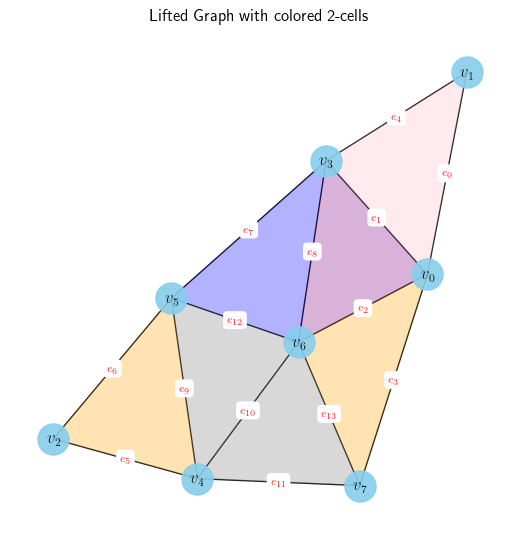

 - The complex has 8 0-cells.
 - The 0-cells have features dimension 1
 - The complex has 14 1-cells.
 - The 1-cells have features dimension 1
 - The complex has 7 2-cells.
 - The 2-cells have features dimension 1



In [4]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset)

# Tangential Complex: theory

(Taken from respective [Gudhi tutorial](https://gudhi.inria.fr/python/latest/tangential_complex_user.html) by Clément Jamin). Tangential complexes were introduced in [1]. A Tangential Delaunay complex is a simplicial complex designed to reconstruct a $k$-dimensional smooth manifold embedded in 
$d$-dimensional Euclidean space.

[1] Jean-Daniel Boissonnat and Arijit Ghosh. Manifold reconstruction using tangential delaunay complexes. _Discrete & Computational Geometry_, 51(1):221–267, 2014. URL: http://dx.doi.org/10.1007/s00454-013-9557-2, doi:10.1007/s00454-013-9557-2.

Consider the following point cloud, being a sample from a 1D curve. 

![](https://gudhi.inria.fr/python/latest/_images/tc_example_01.png)

Tangent subspaces of points are estimated with PCA (more points are needed for that, 4 points are shown here for simplicity):

![](https://gudhi.inria.fr/python/latest/_images/tc_example_02.png)

Now consider a Voronoi diagram of these points shown in orange:

![](https://gudhi.inria.fr/python/latest/_images/tc_example_03.png)

For each point, construct its star in the Delaunay triangulation, restricted to its tangent subspace. The Tangential Delaunay complex is the union of those stars.

In practice, neither the whole ambient Voronoi diagram nor the ambient Delaunay triangulation is computed – instead, local 
$k$-dimensional regular triangulations are computed with a limited number of points as we only need the star of each point. More details can be found in [1].

It is worth noting that inconsistencies between the stars may occur (a simplex is not in the star of all its vertices). One way to fix these inconsistencies is to perturb the points – `gudhi.TangentialComplex` [has methods for that](https://gudhi.inria.fr/python/latest/tangential_complex_ref.html).

In the above example, $k$, the intrinsic dimension of the manifold, was set equal to $d$, the ambient dimension, thus the resulting TC resorted to just Delaunay, hence the presence of 2-cells. It is more practically interesting to use TCs when the data is concentrated near some lower-dimensional embedded manifold.

The **lifting** from the original point cloud to the TC is quite straightforward: the points' features are simply transferred to the nodes (0-simplices) of the TC, then, for higher-order simplices, various lifting methods are possible.

# Create and Run a Simplicial NN Model

In this section a simple model is created to test that the used lifting works as intended. In this case the model uses the `up_laplacian_1` and the `down_laplacian_1` so the lifting should make sure to add them to the data.

In [5]:
from modules.models.simplicial.san import SANModel

model_type = "simplicial"
model_id = "san"
model_config = load_model_config(model_type, model_id)

model = SANModel(model_config, dataset_config)


Model configuration for simplicial SAN:

{'in_channels': None,
 'hidden_channels': 32,
 'out_channels': None,
 'n_layers': 2,
 'n_filters': 2,
 'order_harmonic': 5,
 'epsilon_harmonic': 0.1}


In [6]:
y_hat = model(lifted_dataset.get(0))

If everything is correct the cell above should execute without errors.